In [1]:
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Tuple, Dict

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import kagglehub
import yfinance as yf
from openai import OpenAI
import os
from sklearn.linear_model import LinearRegression
from arch import arch_model



In [2]:
@dataclass
class PaperConfig:
    start_date_train: str = "1998-01-01"
    end_date_train: str = "2015-12-31"
    start_date_test: str = "2016-01-01"
    end_date_test: str = "2019-12-31"

    pca_components: int = 4          # best model in Table II
    hidden_size: int = 32
    dropout: float = 0.3
    batch_size: int = 64
    lr: float = 1e-3
    epochs: int = 500

    # For reproducibility
    seed: int = 42

def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

cfg = PaperConfig()
set_seed(cfg.seed)


In [3]:
def load_spy_data() -> pd.DataFrame:
    """
    Return a DataFrame with index = Date, columns = ['open', 'close', 'volume'].
    """
    # TODO: replace with your actual loading logic
    df = yf.download("^GSPC", start="1998-01-01", end="2021-12-31")
    df = df.rename(columns=str.lower)[['open', 'close', 'volume']]
    df.index = df.index.tz_localize(None)
    return df
    raise NotImplementedError

def load_dxy_data() -> pd.DataFrame:
    dxy_raw = yf.download("DX-Y.NYB", start="1998-01-01", end="2021-12-31", auto_adjust=False)
    df = dxy_raw.rename(columns=str.lower)[['open', 'close', 'volume']]
    df.index = df.index.tz_localize(None)
    return df.rename(columns={
        'open': 'dxy_open',
        'close': 'dxy_close',
        'volume': 'dxy_volume',
    })


def load_yield_data() -> pd.DataFrame:
    """
    Download 3M and 10Y yields from Yahoo and return a flat DataFrame:
    index = Date, columns = ['yield_3m', 'yield_10y'].
    """
    # ^IRX = 13-week T-bill (proxy for 3M), ^TNX = 10Y treasury
    tickers = {"^IRX": "yield_3m", "^TNX": "yield_10y"}

    raw = yf.download(list(tickers.keys()),
                      start="1998-01-01",
                      end="2021-12-31",
                      auto_adjust=False)

    # raw.columns: MultiIndex (field, ticker). We want Close prices.
    close = raw["Close"].copy()        # columns: ['^IRX','^TNX']

    close.columns = [tickers[c] for c in close.columns]
    close.index = close.index.tz_localize(None)

    return close      # columns: ['yield_3m', 'yield_10y']




In [4]:
def load_wsj_headlines() -> pd.DataFrame:
    df_headlines = pd.read_csv(r"wsj_headlines.csv")
    df_headlines = df_headlines.rename(columns={"Date": "date", "Headline": "headline", "Category": "category"})
    df_headlines.index = pd.to_datetime(df_headlines["date"])
    df_headlines = df_headlines[["date","headline", "category"]]
    return df_headlines
    raise NotImplementedError


In [5]:
# Crear el cliente una sola vez (usa OPENAI_API_KEY del entorno)
client = OpenAI()

In [6]:
def embed_headline(text: str) -> np.ndarray:
    """
    Embebe un titular (o cualquier texto corto) usando text-embedding-3-small
    y devuelve un vector np.ndarray de float32.
    """
    resp = client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    # resp.data[0].embedding es la lista de floats que devuelve la API
    return np.array(resp.data[0].embedding, dtype=np.float32)


In [7]:
def build_headline_embeddings(headlines_df: pd.DataFrame) -> pd.DataFrame:
    """
    headlines_df: columns ['date', 'headline']
    Returns DataFrame indexed by date with a column 'embedding' that holds np.array(1536,)
    and also expanded numeric columns if desired.
    """
    rows = []
    for _, row in headlines_df.iterrows():
        emb = embed_headline(row["headline"])
        rows.append({
            "date": row["date"],
            "embedding": emb
        })
    emb_df = pd.DataFrame(rows)
    emb_df["date"] = pd.to_datetime(emb_df["date"]).dt.normalize()
    return emb_df


In [8]:
def select_one_headline_per_day(emb_df: pd.DataFrame) -> pd.DataFrame:
    """
    emb_df: ['date', 'embedding']
    Returns DataFrame indexed by date, exactly one embedding per date.
    """
    # Randomly choose one row per date
    emb_df = emb_df.sample(frac=1.0, random_state=cfg.seed)  # shuffle
    one_per_day = emb_df.drop_duplicates(subset="date", keep="first")
    one_per_day = one_per_day.set_index("date").sort_index()
    return one_per_day


In [9]:
def fit_pca_on_train(embeddings: pd.DataFrame, cfg: PaperConfig) -> Tuple[PCA, pd.DataFrame]:
    """
    embeddings: DataFrame indexed by date, column 'embedding' (np.array)
    Returns fitted PCA and DataFrame with columns ['pca_1', ..., 'pca_k'].
    """
    # Convert list/array column into 2D matrix
    X = np.stack(embeddings["embedding"].values)  # shape (n_days, 1536)

    pca = PCA(n_components=cfg.pca_components, random_state=cfg.seed)
    X_pca = pca.fit_transform(X)

    cols = [f"headline_pca_{i+1}" for i in range(cfg.pca_components)]
    pca_df = pd.DataFrame(X_pca, index=embeddings.index, columns=cols)
    return pca, pca_df


In [10]:
def apply_pca(embeddings: pd.DataFrame, pca: PCA, cfg: PaperConfig) -> pd.DataFrame:
    X = np.stack(embeddings["embedding"].values)
    X_pca = pca.transform(X)
    cols = [f"headline_pca_{i+1}" for i in range(cfg.pca_components)]
    pca_df = pd.DataFrame(X_pca, index=embeddings.index, columns=cols)
    return pca_df

In [11]:
def build_merged_dataset(cfg: PaperConfig) -> pd.DataFrame:
    spy = load_spy_data()
    dxy = load_dxy_data()
    yld = load_yield_data()

    spy.index = pd.to_datetime(spy.index).tz_localize(None)
    dxy.index = pd.to_datetime(dxy.index).tz_localize(None)
    yld.index = pd.to_datetime(yld.index).tz_localize(None)

    spy = spy.sort_index()
    spy["log_ret_next"] = np.log(spy["close"].shift(-1) / spy["close"])

    df = spy[["open", "close", "volume", "log_ret_next"]].copy()
    df = df.join(dxy[["dxy_open"]], how="left")
    df = df.join(yld[["yield_3m", "yield_10y"]], how="left")



    # 3) Headline embeddings (assume precomputed)
    # Suppose you already have a DataFrame 'headline_embs'
    # indexed by date with column 'embedding'.
    # Here we just show the flow.
    raise NotImplementedError("You need to prepare headline_embs DataFrame")


In [12]:
def add_headline_pca_features(df: pd.DataFrame,
                              headline_embs: pd.DataFrame,
                              cfg: PaperConfig) -> Tuple[pd.DataFrame, PCA]:
    """
    df: price+macro DataFrame indexed by date
    headline_embs: DataFrame indexed by date with column 'embedding' (np.array)
    """
    # Align headline embeddings with df index
    emb_aligned = headline_embs.reindex(df.index).dropna(subset=["embedding"])

    # Fit PCA on training period only
    train_mask = (emb_aligned.index >= cfg.start_date_train) & (emb_aligned.index <= cfg.end_date_train)
    emb_train = emb_aligned[train_mask]

    pca, _ = fit_pca_on_train(emb_train, cfg)

    # Transform full (train + test) embeddings
    pca_full = apply_pca(emb_aligned, pca, cfg)   # index = dates where we have embeddings

    # Safely align PCA features to df's index and assign column by column
    pca_full_aligned = pca_full.reindex(df.index)

    for col in pca_full_aligned.columns:
        df[col] = pca_full_aligned[col]

    return df, pca


In [13]:
def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    If df.columns is a MultiIndex like ('open', '^gspc'),
    flatten it to just 'open' (first element of the tuple).
    """
    if isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
    return df


In [14]:
def finalize_dataset(df: pd.DataFrame, cfg: PaperConfig) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """
    Split into train/test, handle missing data, and scale features.
    """

    # --- FLATTEN COLUMNS ---
    df = flatten_columns(df)

    # --- Debug: show columns & check target ---
    print("DEBUG finalize_dataset | columns:", list(df.columns)[:20])
    print("DEBUG finalize_dataset | 'log_ret_next' present?", "log_ret_next" in df.columns)

    # Ensure target column exists
    if "log_ret_next" not in df.columns:
        if "close" not in df.columns:
            raise ValueError(
                "finalize_dataset: df has no 'log_ret_next' and no 'close' to compute it from. "
                f"Columns are: {list(df.columns)}"
            )
        df = df.sort_index()
        df["log_ret_next"] = np.log(df["close"].shift(-1) / df["close"])
        print("DEBUG finalize_dataset | created 'log_ret_next' from 'close'.")

    # Drop rows without target
    df = df.dropna(subset=["log_ret_next"])

    # Define base feature columns
    feature_cols = [
        "open", "close", "volume",
        "dxy_open", "yield_3m", "yield_10y",
    ]

    # Add PCA columns if present
    pca_cols = [c for c in df.columns
                if isinstance(c, str) and c.startswith("headline_pca_")]
    feature_cols += pca_cols

    # Drop rows with missing features (or you could impute)
    df = df.dropna(subset=feature_cols)

    # Train/test split by date
    train_mask = (df.index >= cfg.start_date_train) & (df.index <= cfg.end_date_train)
    test_mask  = (df.index >= cfg.start_date_test)  & (df.index <= cfg.end_date_test)

    train_df = df[train_mask].copy()
    test_df  = df[test_mask].copy()

    X_train = train_df[feature_cols].values
    y_train = train_df["log_ret_next"].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df["log_ret_next"].values

    # Scale features on train only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Store scaled arrays back into the DataFrames
    for i, col in enumerate(feature_cols):
        train_df[col] = X_train_scaled[:, i]
        test_df[col]  = X_test_scaled[:, i]

    return train_df, test_df, scaler


In [15]:
def finalize_dataset_price_target(df: pd.DataFrame, cfg: PaperConfig):
    """
    Version closer to the paper: predict next-day *normalized close* instead of log-return.

    Returns:
        train_df, test_df, scaler, feature_cols
    """
    df = flatten_columns(df)
    df = df.sort_index()

    # --- 1) Compute normalized close using TRAIN-period stats ---
    # Use the *full* df index to find the training window for normalization
    train_window_mask = (df.index >= cfg.start_date_train) & (df.index <= cfg.end_date_train)
    close_train = df.loc[train_window_mask, "close"]

    close_min, close_max = close_train.min(), close_train.max()
    df["close_norm"] = (df["close"] - close_min) / (close_max - close_min)

    # Target: next-day normalized close
    df["close_norm_next"] = df["close_norm"].shift(-1)

    # --- 2) Define feature columns ---
    feature_cols = [
        "close_norm",   # key feature emphasized in the paper
        "open",
        "volume",
        "dxy_open",
        "yield_3m",
        "yield_10y",
    ]

    # Add PCA news features if present
    pca_cols = [c for c in df.columns
                if isinstance(c, str) and c.startswith("headline_pca_")]
    feature_cols += pca_cols

    # --- 3) Drop rows missing target or features ---
    df = df.dropna(subset=["close_norm_next"])
    df = df.dropna(subset=feature_cols)

    # --- 4) Recompute train/test masks AFTER drops (important!) ---
    train_mask = (df.index >= cfg.start_date_train) & (df.index <= cfg.end_date_train)
    test_mask  = (df.index >= cfg.start_date_test)  & (df.index <= cfg.end_date_test)

    train_df = df.loc[train_mask].copy()
    test_df  = df.loc[test_mask].copy()

    # --- 5) Scale features on train only ---
    X_train = train_df[feature_cols].values
    X_test  = test_df[feature_cols].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    for i, col in enumerate(feature_cols):
        train_df[col] = X_train_scaled[:, i]
        test_df[col]  = X_test_scaled[:, i]

    return train_df, test_df, scaler, feature_cols


In [16]:
class TimeIndependentDataset(Dataset):
    def __init__(self, df: pd.DataFrame, feature_cols: list, target_col: str = "log_ret_next"):
        self.X = df[feature_cols].values.astype(np.float32)
        self.y = df[target_col].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [17]:
class FFNN(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int = 32, dropout: float = 0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_size, 1)

        # Xavier init
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [18]:
def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Symmetric Mean Absolute Percentage Error in percent.
    """
    denom = (np.abs(y_true) + np.abs(y_pred))
    # avoid division by zero
    denom = np.where(denom == 0, 1e-8, denom)
    return 100.0 * np.mean(np.abs(y_true - y_pred) / denom * 2.0)


In [19]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                cfg: PaperConfig,
                device: str = "cpu") -> Dict[str, float]:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    model.to(device)

    for epoch in range(cfg.epochs):
        model.train()
        train_losses = []

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Optional: simple validation loss tracking
        if (epoch + 1) % 50 == 0 or epoch == 0:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for X_val, y_val in val_loader:
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    preds = model(X_val)
                    loss = criterion(preds, y_val)
                    val_losses.append(loss.item())

            print(f"Epoch {epoch+1}/{cfg.epochs} "
                  f"Train MSE: {np.mean(train_losses):.6f} "
                  f"Val MSE: {np.mean(val_losses):.6f}")

    # Return model; metrics computed separately
    return {}


In [20]:
def evaluate_model(model: nn.Module,
                   df: pd.DataFrame,
                   feature_cols: list,
                   target_col: str = "log_ret_next",
                   device: str = "cpu") -> Dict[str, float]:
    model.eval()
    X = df[feature_cols].values.astype(np.float32)
    y_true = df[target_col].values.astype(np.float32)

    with torch.no_grad():
        X_tensor = torch.from_numpy(X).to(device)
        y_pred = model(X_tensor).cpu().numpy().flatten()

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    s = smape(y_true, y_pred)

    return {"MSE": mse, "R2": r2, "SMAPE": s}, y_true, y_pred


Embedding que toma tiempo: aprox 1:30 h

In [21]:
df_headlines = load_wsj_headlines()
emb_df = build_headline_embeddings(df_headlines[["date", "headline"]])
one_per_day = select_one_headline_per_day(emb_df)
headline_embs = one_per_day  




In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def evaluate_price_baselines(
    cfg: PaperConfig,
    spy: pd.DataFrame,
    test_df: pd.DataFrame,
    y_test_norm: np.ndarray,
    y_test_real: np.ndarray,
    close_min: float,
    close_max: float,
) -> dict:
    """
    Evaluate two baselines for next-day CLOSE:

      1) Random walk:   Y_{t+1} = Y_t + e_t
      2) AR(1) in level: Y_t = c + phi Y_{t-1} + eps

    All baselines are computed in REAL close units and then mapped to
    normalized space using the same min/max (close_min, close_max).

    Returns:
        {
          "rw_norm":  {MSE, RMSE, MAE, R2},
          "rw_real":  {MSE, RMSE, MAE, R2},
          "ar1_norm": {MSE, RMSE, MAE, R2},
          "ar1_real": {MSE, RMSE, MAE, R2},
        }
    """
    scale = close_max - close_min

    # ---------- Build training series for AR(1) from SPX closes ----------
    train_mask_full = (
        (spy.index >= cfg.start_date_train) &
        (spy.index <= cfg.end_date_train)
    )
    close_train = spy.loc[train_mask_full, "close"].astype(float)

    # AR(1): Y_t = c + phi Y_{t-1} + eps
    # Fit on (Y_{t-1}, Y_t) pairs
    y_ar = close_train.iloc[1:].values.reshape(-1, 1)
    X_ar = close_train.iloc[:-1].values.reshape(-1, 1)

    ar = LinearRegression()
    ar.fit(X_ar, y_ar)
    c_hat = float(ar.intercept_[0])
    phi_hat = float(ar.coef_[0][0])

    # ---------- Build test series ----------
    # For each index t in test_df, target is Y_{t+1}.
    # RW baseline uses Y_t; AR(1) uses c_hat + phi_hat * Y_t.
    Y_t_test = spy.loc[test_df.index, "close"].astype(float).values

    # Random walk baseline: Y_{t+1}^rw = Y_t
    y_rw_real = Y_t_test.copy() * np.random.normal(loc=0.0, scale=np.std(Y_t_test), size=Y_t_test.shape)

    # AR(1) baseline: Y_{t+1}^ar = c_hat + phi_hat * Y_t
    y_ar_real = c_hat + phi_hat * Y_t_test

    # ---------- Metrics in REAL space ----------
    def price_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = mse ** 0.5
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

    metrics_rw_real  = price_metrics(y_test_real, y_rw_real)
    metrics_ar1_real = price_metrics(y_test_real, y_ar_real)

    # ---------- Metrics in NORMALIZED space ----------
    y_rw_norm  = (y_rw_real  - close_min) / scale
    y_ar_norm  = (y_ar_real  - close_min) / scale

    def norm_metrics(y_true_norm, y_pred_norm):
        mse = mean_squared_error(y_true_norm, y_pred_norm)
        rmse = mse ** 0.5
        mae = mean_absolute_error(y_true_norm, y_pred_norm)
        r2 = r2_score(y_true_norm, y_pred_norm)
        return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

    metrics_rw_norm  = norm_metrics(y_test_norm, y_rw_norm)
    metrics_ar1_norm = norm_metrics(y_test_norm, y_ar_norm)

    return {
        "rw_real":  metrics_rw_real,
        "rw_norm":  metrics_rw_norm,
        "ar1_real": metrics_ar1_real,
        "ar1_norm": metrics_ar1_norm,
        "phi_hat":  phi_hat,
        "c_hat":        c_hat,
    }

In [26]:
from arch import arch_model

def analyze_garch_vol_vs_errors(r_true_log,
                                r_pred_log) -> None:
    """
    Fit GARCH(1,1) on r_true_log and analyze if prediction errors are driven by volatility.

    NEW:
    - Applies threshold = mean(vol) + std(vol)
    - Explicitly prints that points above threshold are being removed
    - Prints corr(y_true, y_pred) BEFORE and AFTER filtering
    """

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # 1) Align the two series and drop NaNs
    data = pd.concat({"r_true": r_true_log, "r_pred": r_pred_log}, axis=1).dropna()
    r = data["r_true"]

    # Corr between y_true and y_pred (ALL points)
    corr_true_pred_all = data["r_true"].corr(data["r_pred"])

    # Optional numerical scaling (improves optimizer stability)
    r_scaled = r * 100.0

    # 2) Fit a standard GARCH(1,1) with constant mean
    am = arch_model(r_scaled, mean="Constant", vol="GARCH",
                    p=1, o=0, q=1, dist="normal")
    res = am.fit(disp="off")

    print("\n=== GARCH(1,1) fit on true log returns (scaled x100) ===")
    print(res.summary())

    # 3) Conditional volatility (same index as r_true)
    cond_vol_scaled = res.conditional_volatility
    cond_vol = cond_vol_scaled / 100.0  # back to same scale as returns

    # 4) Prediction errors
    err = data["r_pred"] - data["r_true"]
    abs_err = err.abs()

    # Align volatility with errors
    common = pd.concat(
        {"vol": cond_vol, "err": err, "abs_err": abs_err,
         "r_true": data["r_true"], "r_pred": data["r_pred"]},
        axis=1
    ).dropna()

    # 5) Baseline correlations (no filtering)
    corr_signed = common["err"].corr(common["vol"])
    corr_abs    = common["abs_err"].corr(common["vol"])

    print("\n=== Diagnostics (ALL data) ===")
    print(f"Corr(y_true, y_pred)       : {corr_true_pred_all:.4f}")
    print(f"Corr(vol, signed error)    : {corr_signed:.4f}")
    print(f"Corr(vol, |error|)         : {corr_abs:.4f}")
    print(f"Mean(vol) (daily std dev)  : {common['vol'].mean():.4%}")
    print(f"Mean(|error|)              : {common['abs_err'].mean():.4%}")

    # -----------------------------
    # NEW: Threshold + filtering
    # -----------------------------
    vol_mean = common["vol"].mean()
    vol_std  = common["vol"].std()
    thr = vol_mean + vol_std

    # Flag 0/1 (1 = above threshold)
    common["high_vol"] = (common["vol"] > thr).astype(int)

    # IMPORTANT: Here we "remove" points above threshold (keep only vol <= thr)
    mask_keep = (common["high_vol"] == 0)
    common_f = common.loc[mask_keep].copy()

    removed = (~mask_keep).sum()
    total = len(common)
    kept = len(common_f)

    print("\n=== APPLYING THRESHOLD FILTER ===")
    print("Rule: REMOVE points where vol > (mean(vol) + std(vol))")
    print(f"Mean(vol)     : {vol_mean:.4%}")
    print(f"Std(vol)      : {vol_std:.4%}")
    print(f"Threshold     : {thr:.4%}")
    print(f"Removed points: {removed}/{total} ({removed/total:.2%})")
    print(f"Kept points   : {kept}/{total} ({kept/total:.2%})")

    # Corr between y_true and y_pred AFTER filtering
    corr_true_pred_f = np.nan
    if len(common_f) >= 3 and common_f["r_true"].std() > 0 and common_f["r_pred"].std() > 0:
        corr_true_pred_f = common_f["r_true"].corr(common_f["r_pred"])

    # Recompute diagnostics AFTER filtering
    corr_signed_f = np.nan
    corr_abs_f = np.nan
    if len(common_f) >= 3 and common_f["vol"].std() > 0:
        if common_f["err"].std() > 0:
            corr_signed_f = common_f["err"].corr(common_f["vol"])
        if common_f["abs_err"].std() > 0:
            corr_abs_f = common_f["abs_err"].corr(common_f["vol"])

    print("\n=== Diagnostics (AFTER filtering) ===")
    print(f"Corr(y_true, y_pred)       : {corr_true_pred_f:.4f}")
    print(f"Corr(vol, signed error)    : {corr_signed_f:.4f}")
    print(f"Corr(vol, |error|)         : {corr_abs_f:.4f}")
    print(f"Mean(vol) (filtered)       : {common_f['vol'].mean():.4%}")
    print(f"Mean(|error|) (filtered)   : {common_f['abs_err'].mean():.4%}")

    # 6) Plots

    # Time series: volatility vs |error| + threshold line
    plt.figure(figsize=(12, 4))
    plt.plot(common.index, common["vol"].values, label="GARCH cond. vol (σ_t)", alpha=0.7)
    plt.plot(common.index, common["abs_err"].values, label="|prediction error|", alpha=0.7)
    plt.axhline(thr, linestyle="--", linewidth=1.2, label="threshold = mean(vol)+std(vol)")
    plt.title("GARCH volatility vs |return prediction error| (log returns)")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Scatter: volatility vs |error| (colored by removed/kept)
    plt.figure(figsize=(6, 5))
    colors = common["high_vol"].map({0: "C0", 1: "C1"})
    plt.scatter(common["vol"].values, common["abs_err"].values, c=colors, alpha=0.6, s=12)
    plt.axvline(thr, linestyle="--", linewidth=1.2, label="threshold")
    plt.title("Scatter: volatility vs |prediction error| (kept vs removed)")
    plt.xlabel("GARCH cond. vol (σ_t)")
    plt.ylabel("|prediction error|")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [27]:
# %% ------------------------------------------------------------
# Main "best paper model" with normalized-price target
# ---------------------------------------------------------------
def run_best_paper_model_price_target(cfg: PaperConfig,
                                      headline_embs: pd.DataFrame) -> None:
    """
    Approximate replication of the paper's best model, but with
    normalized price target instead of raw log-return.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import (
        mean_squared_error,
        r2_score,
        mean_absolute_error,
    )

    # 1) Base SPX + macro data
    spy = load_spy_data()
    dxy = load_dxy_data()
    yld = load_yield_data()

    for frame in (spy, dxy, yld):
        if isinstance(frame.index, pd.MultiIndex):
            frame.index = frame.index.get_level_values(0)
        frame.index = pd.to_datetime(frame.index).tz_localize(None)

    spy = spy.sort_index()

    # Base df (no log_ret_next target here)
    df = spy[["open", "close", "volume"]].copy()
    df["dxy_open"]  = dxy["dxy_open"].reindex(df.index)
    df["yield_3m"]  = yld["yield_3m"].reindex(df.index)
    df["yield_10y"] = yld["yield_10y"].reindex(df.index)

    # 2) Add PCA headline features
    if headline_embs is not None:
        df, pca = add_headline_pca_features(df, headline_embs, cfg)

    # 3) Build normalized-price dataset
    train_df, test_df, scaler, feature_cols = finalize_dataset_price_target(df, cfg)

    # 4) Inner train/val split (time-based) on TRAIN period
    train_mask_inner = train_df.index < "2014-01-01"
    val_mask_inner   = train_df.index >= "2014-01-01"

    train_inner = train_df[train_mask_inner]
    val_inner   = train_df[val_mask_inner]

    train_dataset = TimeIndependentDataset(
        train_inner, feature_cols, target_col="close_norm_next"
    )
    val_dataset   = TimeIndependentDataset(
        val_inner, feature_cols, target_col="close_norm_next"
    )

    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False)

    # 5) Model
    input_dim = len(feature_cols)
    model = FFNN(
        input_dim=input_dim,
        hidden_size=cfg.hidden_size,
        dropout=cfg.dropout,
    )
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 6) Train
    train_model(model, train_loader, val_loader, cfg, device=device)

    # 7) Evaluate on normalized-price target
    train_metrics, _, _ = evaluate_model(
        model, train_df, feature_cols, target_col="close_norm_next", device=device
    )
    test_metrics, y_test_norm, y_pred_norm = evaluate_model(
        model, test_df, feature_cols, target_col="close_norm_next", device=device
    )

    print("Train metrics (normalized price):", train_metrics)
    print("Test  metrics (normalized price):", test_metrics)

    # 8) Plot normalized price true vs predicted
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test_norm, label="True norm. close", alpha=0.7)
    plt.plot(test_df.index, y_pred_norm, label="Pred norm. close", alpha=0.7)
    plt.title("Next-day normalized close: true vs predicted (test set)")
    plt.xlabel("Date")
    plt.ylabel("Normalized price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 9) Denormalize predictions (REAL units) + metrics + plots
    # Same min/max as used inside finalize_dataset_price_target
    train_mask_full = (df.index >= cfg.start_date_train) & (df.index <= cfg.end_date_train)
    close_min = float(df.loc[train_mask_full, "close"].min())
    close_max = float(df.loc[train_mask_full, "close"].max())
    scale = close_max - close_min

    # Inverse min-max transform
    y_test_real = y_test_norm * scale + close_min
    y_pred_real = y_pred_norm * scale + close_min

    # Metrics in normalized space (recomputed)
    mse_norm = mean_squared_error(y_test_norm, y_pred_norm)
    r2_norm  = r2_score(y_test_norm, y_pred_norm)

    # Metrics in real space
    mse_real = mean_squared_error(y_test_real, y_pred_real)
    r2_real  = r2_score(y_test_real, y_pred_real)
    rmse_real = mse_real ** 0.5
    mae_real  = mean_absolute_error(y_test_real, y_pred_real)

    print("\n--- Denormalization info ---")
    print(f"close_min(train)={close_min:.6f} close_max(train)={close_max:.6f} scale={scale:.6f}")

    print("\nMetrics (recomputed) - NORMALIZED target:")
    print({"MSE": mse_norm, "R2": r2_norm})

    print("\nMetrics - REAL close units (model):")
    print({"MSE": mse_real, "RMSE": rmse_real, "MAE": mae_real, "R2": r2_real})

        # 10) Baseline comparison: random walk + AR(1)
    baselines = evaluate_price_baselines(
        cfg=cfg,
        spy=spy,
        test_df=test_df,
        y_test_norm=y_test_norm,
        y_test_real=y_test_real,
        close_min=close_min,
        close_max=close_max,
    )

    print("\n=== Baselines for next-day CLOSE ===")
    print(f"Random walk (REAL): {baselines['rw_real']}")
    print(f"Random walk (NORM): {baselines['rw_norm']}")
    print(f"AR(1)       (REAL): {baselines['ar1_real']}")
    print(f"AR(1)       (NORM): {baselines['ar1_norm']}")
    print(f"Estimated AR(1) parameters: phi={baselines['phi_hat']:.4f}, c={baselines['c_hat']:.4f}")

    print("\n=== NN model (REAL close units) ===")
    print({"MSE": mse_real, "RMSE": rmse_real, "MAE": mae_real, "R2": r2_real})


    # 11) Plot real close: true vs predicted
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test_real, label="True close", alpha=0.7)
    plt.plot(test_df.index, y_pred_real, label="Pred close", alpha=0.7)
    plt.title("Next-day close (REAL units): true vs predicted (test set)")
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 12) Error in points
    plt.figure(figsize=(12, 3))
    plt.plot(test_df.index, (y_pred_real - y_test_real), label="Error (Pred - True)", alpha=0.8)
    plt.axhline(0.0, linewidth=1)
    plt.title("Prediction error in REAL units (points)")
    plt.xlabel("Date")
    plt.ylabel("Points")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 13) Returns using shift(1) on y_test_real and y_pred_real
    eps = 1e-12

    # Convert to pandas Series to use shift neatly (index = test_df.index)
    y_true_ser = pd.Series(y_test_real, index=test_df.index)
    y_pred_ser = pd.Series(y_pred_real, index=test_df.index)

    # Shifted denominators (t-1)
    y_true_prev = y_true_ser.shift(1)
    y_pred_prev = y_pred_ser.shift(1)

    # --- SIMPLE returns ---
    r_true_simple = (y_true_ser / (y_true_prev + eps)) - 1.0
    r_pred_simple = (y_pred_ser / (y_pred_prev + eps)) - 1.0

    # drop first NaN (and any others)
    mask_s = r_true_simple.notna() & r_pred_simple.notna()
    r_true_simple = r_true_simple[mask_s]
    r_pred_simple = r_pred_simple[mask_s]

    mse_s = mean_squared_error(r_true_simple, r_pred_simple)
    r2_s  = r2_score(r_true_simple, r_pred_simple)
    rmse_s = np.sqrt(mse_s)
    mae_s  = mean_absolute_error(r_true_simple, r_pred_simple)

    print("\nMetrics - SIMPLE returns (using shift(1) on true/pred series):")
    print({"MSE": mse_s, "RMSE": rmse_s, "MAE": mae_s, "R2": r2_s})

    plt.figure(figsize=(12, 4))
    plt.plot(r_true_simple.index, r_true_simple.values, label="True simple return", alpha=0.7)
    plt.plot(r_pred_simple.index, r_pred_simple.values, label="Pred simple return", alpha=0.7)
    plt.title("Next-day SIMPLE return (shift method): true vs predicted")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(
        r_true_simple.index,
        (r_pred_simple - r_true_simple).values,
        label="Error (Pred - True)",
        alpha=0.8,
    )
    plt.axhline(0.0, linewidth=1)
    plt.title("SIMPLE return error (shift method)")
    plt.xlabel("Date")
    plt.ylabel("Return error")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- LOG returns ---
    r_true_log = np.log((y_true_ser + eps) / (y_true_prev + eps))
    r_pred_log = np.log((y_pred_ser + eps) / (y_pred_prev + eps))

    mask_l = r_true_log.notna() & r_pred_log.notna()
    r_true_log = r_true_log[mask_l]
    r_pred_log = r_pred_log[mask_l]
    
    mse_l = mean_squared_error(r_true_log, r_pred_log)
    r2_l  = r2_score(r_true_log, r_pred_log)
    rmse_l = np.sqrt(mse_l)
    mae_l  = mean_absolute_error(r_true_log, r_pred_log)

    print("\nMetrics - LOG returns (using shift(1) on true/pred series):")
    print({"MSE": mse_l, "RMSE": rmse_l, "MAE": mae_l, "R2": r2_l})

    plt.figure(figsize=(12, 4))
    plt.plot(r_true_log.index, r_true_log.values, label="True log return", alpha=0.7)
    plt.plot(r_pred_log.index, r_pred_log.values, label="Pred log return", alpha=0.7)
    plt.title("Next-day LOG return (shift method): true vs predicted")
    plt.xlabel("Date")
    plt.ylabel("Log return")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(
        r_true_log.index,
        (r_pred_log - r_true_log).values,
        label="Error (Pred - True)",
        alpha=0.8,
    )
    plt.axhline(0.0, linewidth=1)
    plt.title("LOG return error (shift method)")
    plt.xlabel("Date")
    plt.ylabel("Log return error")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 14) Histograms of returns (true vs predicted)
    # SIMPLE
    plt.figure(figsize=(8, 4))
    plt.hist(r_true_simple.values, bins=50, alpha=0.6, label="True simple returns")
    plt.hist(r_pred_simple.values, bins=50, alpha=0.6, label="Pred simple returns")
    plt.title("Histogram of SIMPLE returns (true vs predicted)")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # LOG
    plt.figure(figsize=(8, 4))
    plt.hist(r_true_log.values, bins=50, alpha=0.6, label="True log returns")
    plt.hist(r_pred_log.values, bins=50, alpha=0.6, label="Pred log returns")
    plt.title("Histogram of LOG returns (true vs predicted)")
    plt.xlabel("Log return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

    corr_log = np.corrcoef(r_true_log.values, r_pred_log.values)[0, 1]
    hit_log  = np.mean(np.sign(r_true_log.values) == np.sign(r_pred_log.values))
    print(f"Correlation (log returns): {corr_log:.4f}")
    print(f"Hit rate (log returns)   : {hit_log*100:.2f}%")
    
    analyze_garch_vol_vs_errors(r_true_log, r_pred_log)


/tmp/ipykernel_413792/4064750746.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start="1998-01-01", end="2021-12-31")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


Epoch 1/500 Train MSE: 0.329152 Val MSE: 0.036197
Epoch 50/500 Train MSE: 0.001433 Val MSE: 0.000865
Epoch 100/500 Train MSE: 0.000861 Val MSE: 0.000375
Epoch 150/500 Train MSE: 0.000689 Val MSE: 0.000523
Epoch 200/500 Train MSE: 0.000737 Val MSE: 0.000172
Epoch 250/500 Train MSE: 0.000673 Val MSE: 0.001409
Epoch 300/500 Train MSE: 0.000648 Val MSE: 0.000606
Epoch 350/500 Train MSE: 0.000660 Val MSE: 0.000302
Epoch 400/500 Train MSE: 0.000662 Val MSE: 0.000366
Epoch 450/500 Train MSE: 0.000679 Val MSE: 0.000624
Epoch 500/500 Train MSE: 0.000651 Val MSE: 0.000166
Train metrics (normalized price): {'MSE': np.float32(0.00011892765), 'R2': 0.997408926486969, 'SMAPE': np.float32(2.7293756)}
Test  metrics (normalized price): {'MSE': np.float32(0.0003022144), 'R2': 0.9942452311515808, 'SMAPE': np.float32(1.0703076)}


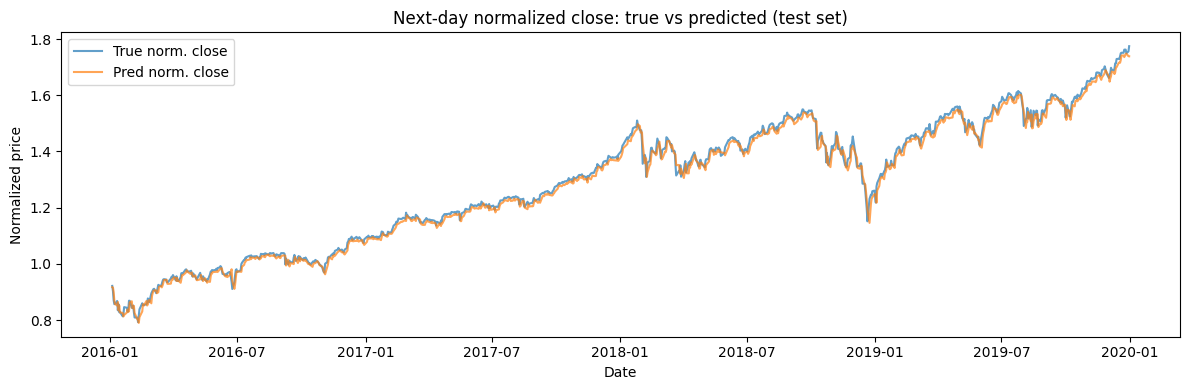


--- Denormalization info ---
close_min(train)=676.530029 close_max(train)=2130.820068 scale=1454.290039

Metrics (recomputed) - NORMALIZED target:
{'MSE': np.float32(0.0003022144), 'R2': 0.9942452311515808}

Metrics - REAL close units (model):
{'MSE': np.float32(639.17126), 'RMSE': np.float32(25.281837), 'MAE': np.float32(19.96613), 'R2': 0.9942452311515808}

=== Baselines for next-day CLOSE ===
Random walk (REAL): {'MSE': np.float64(720270234871.1191), 'RMSE': np.float64(848687.3599100667), 'MAE': np.float64(670087.3625056455), 'R2': -6484950.490780571}
Random walk (NORM): {'MSE': np.float64(340559.82104694896), 'RMSE': np.float64(583.5750346330358), 'MAE': np.float64(460.76597137220847), 'R2': -6484950.433728453}
AR(1)       (REAL): {'MSE': np.float64(424.16780253275283), 'RMSE': np.float64(20.595334484604827), 'MAE': np.float64(13.937664603084688), 'R2': 0.9961810061138121}
AR(1)       (NORM): {'MSE': np.float64(0.00020055598234780257), 'RMSE': np.float64(0.014161778925961335), 'MA

/tmp/ipykernel_413792/1755137139.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_min = float(df.loc[train_mask_full, "close"].min())
/tmp/ipykernel_413792/1755137139.py:98: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_max = float(df.loc[train_mask_full, "close"].max())


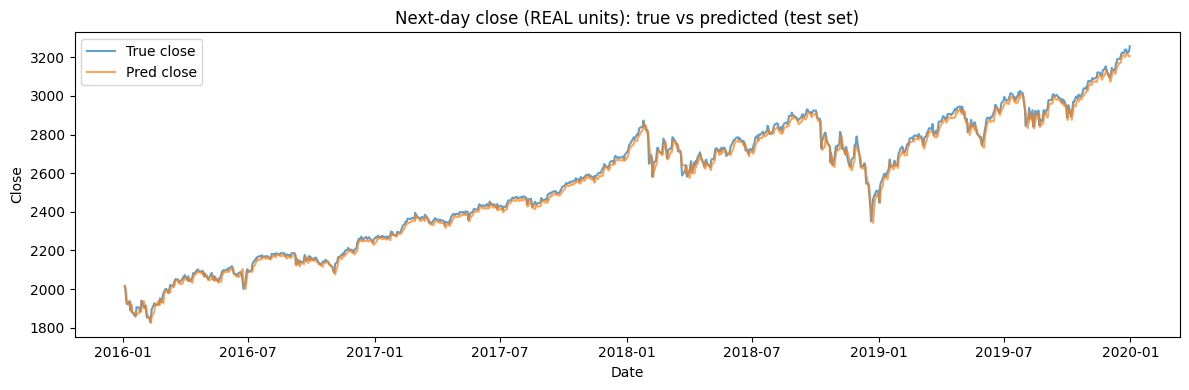

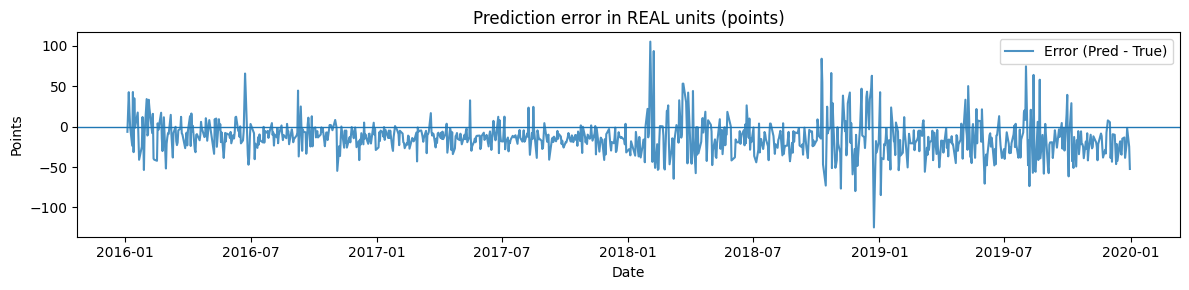


Metrics - SIMPLE returns (using shift(1) on true/pred series):
{'MSE': np.float32(0.000120053315), 'RMSE': np.float32(0.010956884), 'MAE': np.float32(0.007641374), 'R2': -0.7982953786849976}


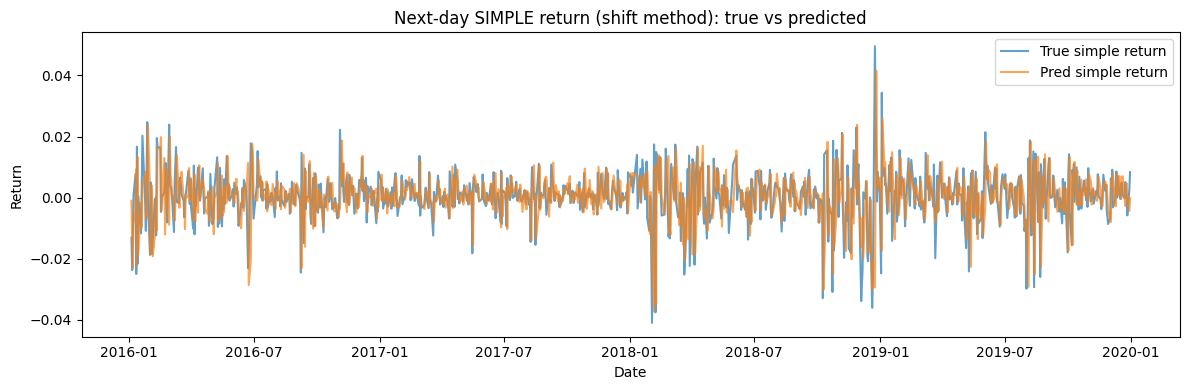

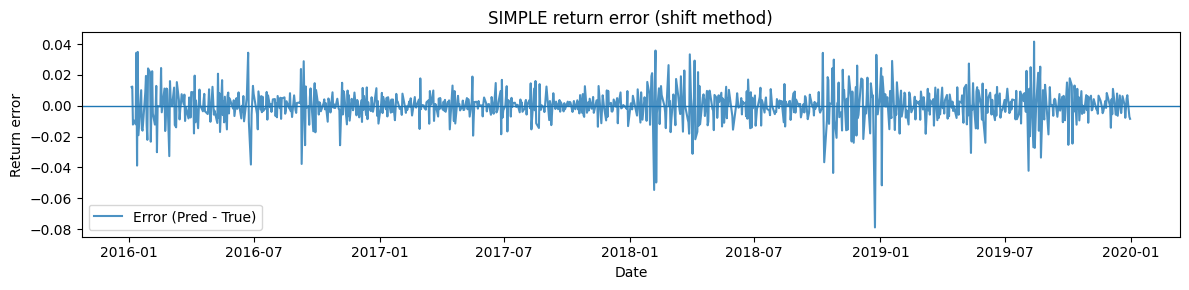


Metrics - LOG returns (using shift(1) on true/pred series):
{'MSE': np.float32(0.00012032609), 'RMSE': np.float32(0.010969325), 'MAE': np.float32(0.007643677), 'R2': -0.7944583892822266}


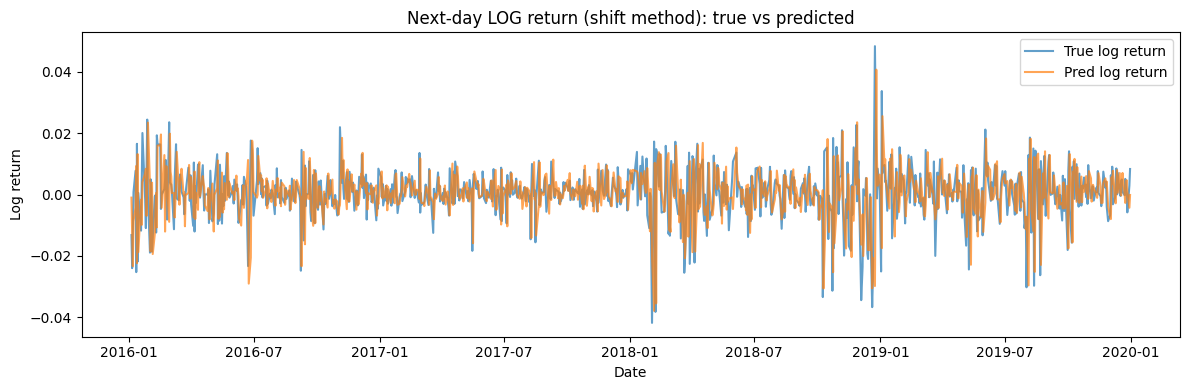

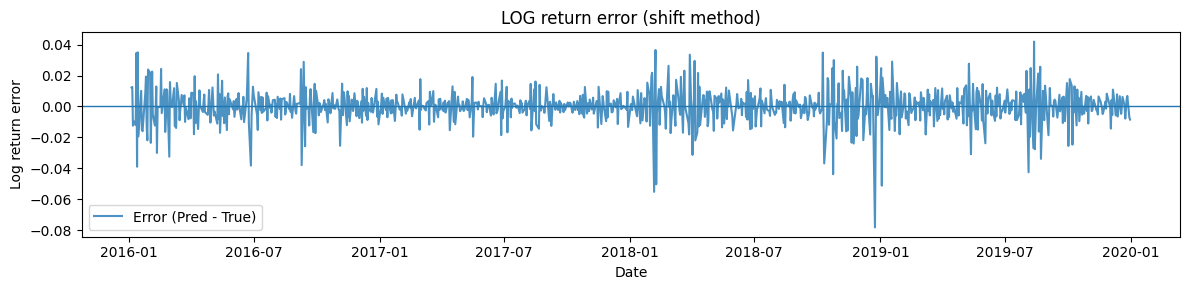

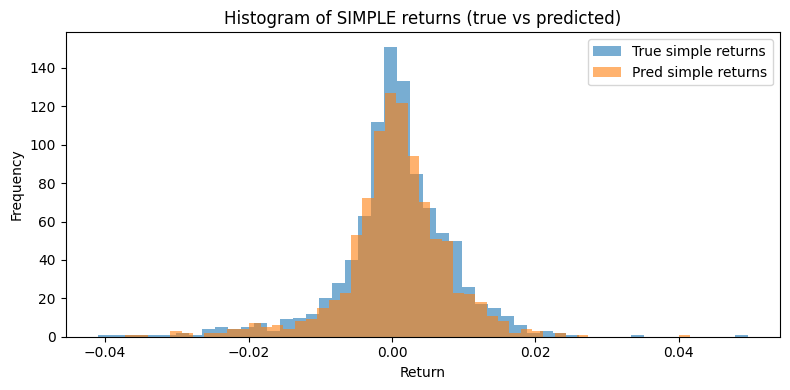

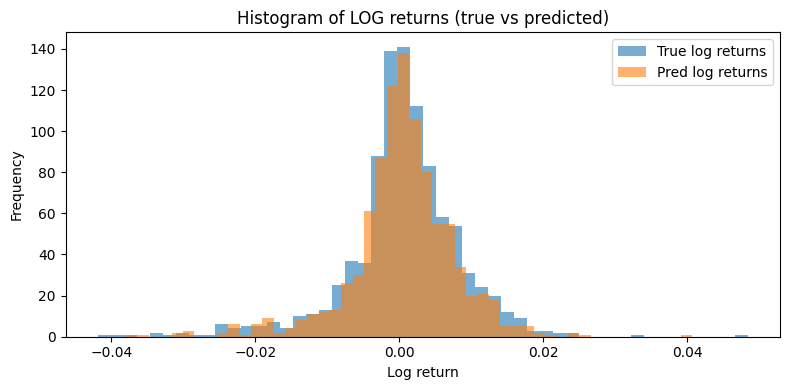

Correlation (log returns): 0.0181
Hit rate (log returns)   : 49.58%

=== GARCH(1,1) fit on true log returns (scaled x100) ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 r_true   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1019.85
Distribution:                  Normal   AIC:                           2047.70
Method:            Maximum Likelihood   BIC:                           2067.15
                                        No. Observations:                  956
Date:                Fri, Dec 19 2025   Df Residuals:                      955
Time:                        14:39:48   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-------------

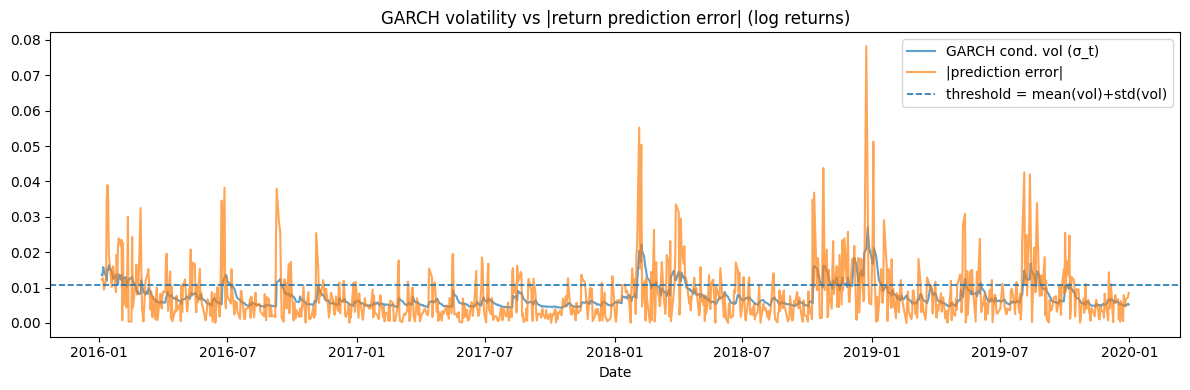

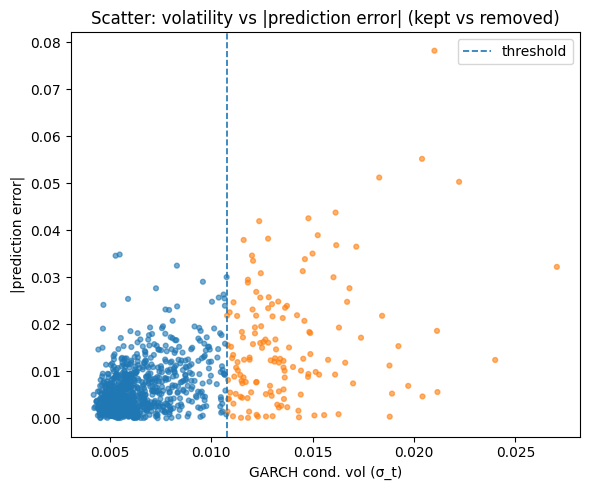

In [28]:
run_best_paper_model_price_target(cfg, headline_embs=headline_embs)